# Import


In [ ]:
!pip install transformers datasets optuna accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 113.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjit

In [ ]:
# --- ⚙️ Stage 0: Imports and Initial Setup ---
print("🚀 Stage 0: Initializing - Importing libraries...")
import pandas as pd
import numpy as np
import torch
import gc
import optuna
import spacy
import unicodedata
import re
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset, concatenate_datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

# Optional: For Data Augmentation (if you find it necessary later)
# !pip install nlpaug -q
# import nlpaug.augmenter.word as naw

🚀 Stage 0: Initializing - Importing libraries...


# Preprocessing


In [ ]:
# Ensure reproducibility where possible
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Libraries imported.")

# --- 🛠️ Stage 1: Configuration ---
print("\n--- 🛠️ Stage 1: Configuration ---")

TASK_NAME = "RAI_event_classifier_ModernBERT_FullFT"
MODEL_ID = "answerdotai/ModernBERT-large"

# !!! ACTION REQUIRED: Update this path to your uploaded Excel file !!!
DATA_PATH = '/content/RAI_event_coding_05272025.xlsx'

TEXT_COLUMN_TITLE = "title_translated"
TEXT_COLUMN_MAIN = "maintext_translated"
INPUT_TEXT_COLUMN = "final_model_input_text" # Name for the combined text column
LABEL_COLUMN = "Event_coding" # Your target label

# Path to save preprocessed data
SAVED_PREPROCESSED_DATA_PATH = '/content/preprocessed_rai_event_data.csv'

# Fine-tuning & Evaluation Settings
HP_SEARCH_VAL_SIZE = 0.15 # Use 15% of data for validation during HP search
N_SPLITS_FOR_CV = 5    # Number of folds for final evaluation
RANDOM_STATE_SPLIT = SEED
MAX_SEQ_LENGTH = 256   # Adjust based on text length analysis; ModernBERT can handle more but uses more memory



# Optuna Settings
N_OPTUNA_TRIALS = 20 # Number of trials for hyperparameter search (increase if time allows)

print(f"Model: {MODEL_ID}")
print(f"Task: {TASK_NAME}")
print(f"Input Text: Concatenation of '{TEXT_COLUMN_TITLE}' and first two sentences of '{TEXT_COLUMN_MAIN}'")
print(f"Target Label: '{LABEL_COLUMN}'")
print(f"Data Path (VERIFY THIS!): {DATA_PATH}")

# --- 🧹 Stage 2: Preprocessing ---
print("\n--- 🧹 Stage 2: Data Preprocessing ---")

# Load spaCy model for sentence tokenization
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading spaCy 'en_core_web_sm' model...")
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")
print("spaCy model loaded.")

def moderate_clean_text(text: str) -> str:
    """Moderately cleans text: Unicode norm, removes control chars, extra spaces."""
    if not isinstance(text, str):
        return ""
    text = unicodedata.normalize("NFC", text)
    text = re.sub(r'[\x00-\x09\x0B\x0C\x0E-\x1F]+', ' ', text)
    text = re.sub(r'[\n\r\t]+', ' ', text)
    text = re.sub(r'[^a-zA-Z\u00C0-\u024F0-9\s\.,;:\-\'\"?!()&%$@#=_/\\]+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def extract_sentences_adaptive_length(text: str,
                                      initial_sentences: int = 2,
                                      max_sentences: int = 4,
                                      min_chars: int = 100) -> str:
    """
    Extracts sentences from text adaptively.
    Starts with `initial_sentences`, then adds more sentences one by one
    until `min_chars` is met or `max_sentences` are extracted.
    """
    if not isinstance(text, str) or not text.strip():
        return ""  # Return empty string for non-string or empty inputs

    doc = nlp(text)
    all_sents = list(doc.sents)

    if not all_sents:
        return ""

    extracted_sents_text = []
    current_char_count = 0
    num_extracted = 0

    # Start with initial_sentences
    for i in range(min(initial_sentences, len(all_sents))):
        extracted_sents_text.append(all_sents[i].text.strip())
        num_extracted += 1

    current_char_count = len(" ".join(extracted_sents_text))

    # Add more sentences if needed and within limits
    while num_extracted < max_sentences and current_char_count < min_chars and num_extracted < len(all_sents):
        next_sentence = all_sents[num_extracted].text.strip()
        extracted_sents_text.append(next_sentence)
        num_extracted += 1
        current_char_count = len(" ".join(extracted_sents_text)) # Recalculate total char length

    return " ".join(extracted_sents_text)

Libraries imported.

--- 🛠️ Stage 1: Configuration ---
Model: answerdotai/ModernBERT-large
Task: RAI_event_classifier_ModernBERT_FullFT
Input Text: Concatenation of 'title_translated' and first two sentences of 'maintext_translated'
Target Label: 'Event_coding'
Data Path (VERIFY THIS!): /content/RAI_event_coding_05272025.xlsx

--- 🧹 Stage 2: Data Preprocessing ---
spaCy model loaded.


In [ ]:
# Load data
try:
    df_full = pd.read_excel(DATA_PATH)
    print(f"Successfully read data from '{DATA_PATH}'. Original Shape: {df_full.shape}")
except FileNotFoundError:
    print(f"CRITICAL Error: Data file '{DATA_PATH}' not found. Please upload it and verify the path.")
    raise SystemExit()
except Exception as e:
    print(f"CRITICAL Error reading data file: {e}")
    raise SystemExit()

# Verify required columns
required_input_cols = [TEXT_COLUMN_TITLE, TEXT_COLUMN_MAIN, LABEL_COLUMN]
for col in required_input_cols:
    if col not in df_full.columns:
        print(f"CRITICAL Error: Required column '{col}' not found in the Excel file.")
        raise SystemExit()

# Initial cleaning and text construction
print("Cleaning text columns...")
df_full[TEXT_COLUMN_TITLE] = df_full[TEXT_COLUMN_TITLE].apply(moderate_clean_text)
df_full[TEXT_COLUMN_MAIN] = df_full[TEXT_COLUMN_MAIN].apply(moderate_clean_text)
print("Extracting first two sentences from main text...")
df_full['extracted_maintext_sentences'] = df_full[TEXT_COLUMN_MAIN].apply(
    lambda x: extract_sentences_adaptive_length(x) # Uses default initial=2, max=4, min_chars=100
)
df_full[INPUT_TEXT_COLUMN] = df_full[TEXT_COLUMN_TITLE] + ". " + df_full['extracted_maintext_sentences'] # NEW

Successfully read data from '/content/RAI_event_coding_05272025.xlsx'. Original Shape: (10340, 7)
Cleaning text columns...
Extracting first two sentences from main text...


In [ ]:
# --- 🧐 Stage 2.1: Anomaly Check - Very Short Combined Texts ---
print("\n--- 🧐 Stage 2.1: Anomaly Check - Short Combined Texts (< 50 chars) ---")

# Ensure the input text column is treated as string before calculating length
df_full['combined_text_char_length'] = df_full[INPUT_TEXT_COLUMN].astype(str).str.len()

# Filter for rows where the character length of the combined input text is less than 20
short_combined_texts_df = df_full[df_full['combined_text_char_length'] < 50]

if not short_combined_texts_df.empty:
  print(f"Found {len(short_combined_texts_df)} rows where the combined input text ('{INPUT_TEXT_COLUMN}') is less than 20 characters long:")

  # Define columns to display for review
  # We'll definitely want to see the short text and its label.
  # Adding URL and original title if they exist in your df_full can help locate the source.
  display_cols = [INPUT_TEXT_COLUMN, LABEL_COLUMN] # LABEL_COLUMN here is 'Event_coding'
  if 'url' in df_full.columns:
      display_cols.append('url')
  if TEXT_COLUMN_TITLE in df_full.columns: # TEXT_COLUMN_TITLE is 'title_translated'
        display_cols.append(TEXT_COLUMN_TITLE)
  if 'extracted_maintext_sentences' in df_full.columns: # Show the extracted sentences
      display_cols.append('extracted_maintext_sentences')

  # Temporarily increase max column width to see more of the text
  with pd.option_context('display.max_colwidth', 100):
      print(short_combined_texts_df[display_cols])

  print(f"\nPlease review these {len(short_combined_texts_df)} rows. You may want to:")
  print("1. Remove them from the dataset if they are erroneous or uninformative.")
  print("2. Investigate the source to see if more meaningful text can be extracted.")
  print("3. Replace them with a placeholder if removal significantly impacts a rare class (though removal is often better for such short/noisy data).")
else:
  print(f"✅ No rows found where the combined input text ('{INPUT_TEXT_COLUMN}') is less than 20 characters long.")

# --- End of Anomaly Check ---


--- 🧐 Stage 2.1: Anomaly Check - Short Combined Texts (< 50 chars) ---
Found 8 rows where the combined input text ('final_model_input_text') is less than 20 characters long:
                                final_model_input_text Event_coding  \
7444                            Fun photos. Fun photos         -999   
7569                e-easy/12 August. e-easy/12 August         -999   
7600   Illing: There's no excuse for magic.. .........         -999   
7899            Gran interés científico. I don't know.         -999   
7973                 Tevo is a bronze morgue today.. .         -999   
8279  25 court staff have been transferred to Çağan. .         -999   
9156    WINXO advocates its Moroccanity. - No, no, no.         -999   
9347          Extra bus limit in holiday C (s). ......         -999   

                                                                                                      url  \
7444                                 https://www.posta.com.tr/eglenceli-foto

In [ ]:
indices_to_drop = short_combined_texts_df.index.tolist()
print(f"Indices to drop: {indices_to_drop}")
try:
    df_full.drop(indices_to_drop, inplace=True)
    print(f"Rows with indices {indices_to_drop} have been dropped.")
    print(f"New shape of the DataFrame: {df_full.shape}")
except KeyError:
    print(f"Error: One or more indices in {indices_to_drop} were not found in the DataFrame. Please check your indices.")
except NameError:
    print("Error: 'your_dataframe' is not defined. Please make sure your DataFrame is loaded and named correctly.")


Indices to drop: [7444, 7569, 7600, 7899, 7973, 8279, 9156, 9347]
Rows with indices [7444, 7569, 7600, 7899, 7973, 8279, 9156, 9347] have been dropped.
New shape of the DataFrame: (10329, 11)


Number of rows after initial processing and NaN drop: 10329

Analyzing input text lengths...
count    10329.000000
mean        59.347371
std         22.553701
min          6.000000
25%         42.000000
50%         58.000000
75%         75.000000
max        268.000000
Name: text_length, dtype: float64


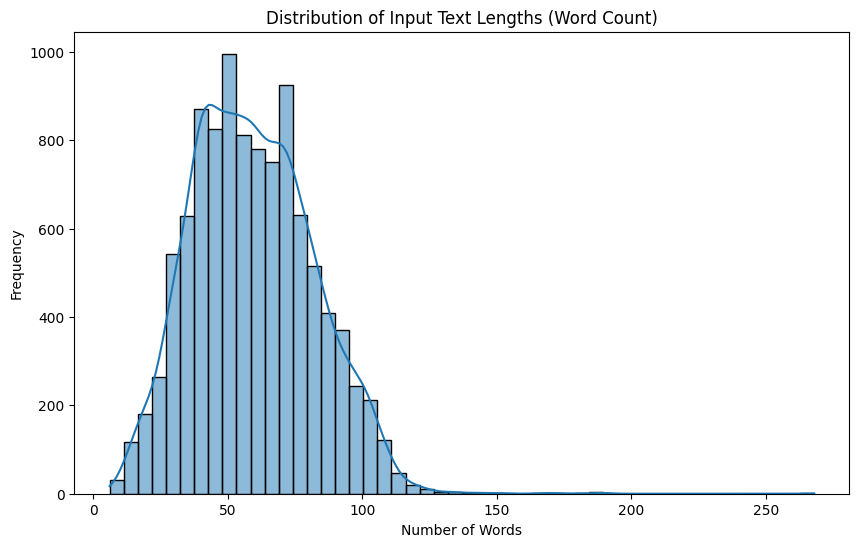

Recommended MAX_SEQ_LENGTH could be around 99 based on 95th percentile word count, but consider token count.


In [ ]:


# Drop rows if critical inputs are missing after construction
df_full.dropna(subset=[INPUT_TEXT_COLUMN, LABEL_COLUMN], inplace=True)
# Clean labels
df_full[LABEL_COLUMN] = df_full[LABEL_COLUMN].astype(str).str.strip()
df_full = df_full[df_full[LABEL_COLUMN].str.len() > 0] # Remove rows with empty labels
df_full = df_full[df_full[INPUT_TEXT_COLUMN].str.strip().str.len() > 0] # Remove rows with empty input text

print(f"Number of rows after initial processing and NaN drop: {len(df_full)}")
if len(df_full) == 0:
    raise ValueError("No data remaining after processing. Check input file and column names.")

# Analyze input text length
print("\nAnalyzing input text lengths...")
df_full['text_length'] = df_full[INPUT_TEXT_COLUMN].apply(lambda x: len(x.split()))
print(df_full['text_length'].describe())
plt.figure(figsize=(10, 6))
sns.histplot(df_full['text_length'], bins=50, kde=True)
plt.title('Distribution of Input Text Lengths (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()
print(f"Recommended MAX_SEQ_LENGTH could be around {int(np.percentile(df_full['text_length'], 95))} based on 95th percentile word count, but consider token count.")

# Data Prep



Preparing labels...
Label Mapping (id2label): {0: '-999', 1: 'arms_transfer_security_aid_assistance', 2: 'bribery_economic_corruption', 3: 'cyber_attack', 4: 'diplomatic_action', 5: 'diplomatic_mediation', 6: 'diplomatic_meeting', 7: 'diplomatic_statement', 8: 'diplomatic_ties', 9: 'foreign_aid_assistance', 10: 'foreign_investment', 11: 'intelligence_counterintelligence', 12: 'joint_security_force_exercise', 13: 'media_campaign_intervention', 14: 'military_activity', 15: 'political_process_policy_intervention', 16: 'security_engagement', 17: 'social_academic_cultural_activity', 18: 'tech_transfer_investment', 19: 'trade_agreement_exchange', 20: 'trade_financial_sanction', 21: 'transnational_organization_crime'}
Number of unique event classes: 22

Visualizing label distribution...


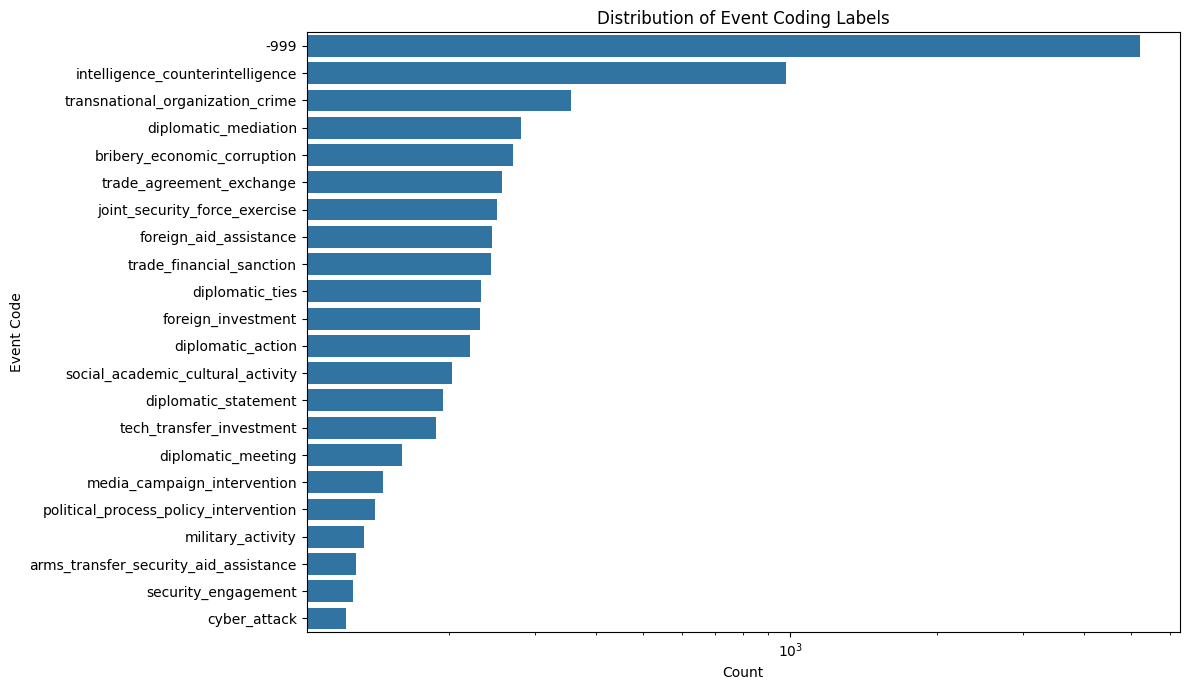

Event_coding
-999                                     50.547004
intelligence_counterintelligence          9.468487
transnational_organization_crime          3.436925
diplomatic_mediation                      2.720496
bribery_economic_corruption               2.613999
trade_agreement_exchange                  2.488140
joint_security_force_exercise             2.420370
foreign_aid_assistance                    2.371962
trade_financial_sanction                  2.362281
diplomatic_ties                           2.246103
foreign_investment                        2.236422
diplomatic_action                         2.129925
social_academic_cultural_activity         1.965340
diplomatic_statement                      1.878207
tech_transfer_investment                  1.820118
diplomatic_meeting                        1.549037
media_campaign_intervention               1.413496
political_process_policy_intervention     1.365089
military_activity                         1.297318
arms_transfer_secu

In [ ]:
# Prepare labels
df_full = pd.read_csv(SAVED_PREPROCESSED_DATA_PATH)
print("\nPreparing labels...")
unique_labels = sorted(df_full[LABEL_COLUMN].unique())
num_labels = len(unique_labels)
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}
df_full['labels'] = df_full[LABEL_COLUMN].map(label2id)

print(f"Label Mapping (id2label): {id2label}")
print(f"Number of unique event classes: {num_labels}")

# Visualize Label Distribution
print("\nVisualizing label distribution...")
plt.figure(figsize=(12, 7))
sns.countplot(y=df_full[LABEL_COLUMN], order = df_full[LABEL_COLUMN].value_counts().index)
plt.title('Distribution of Event Coding Labels')
plt.xlabel('Count')
plt.ylabel('Event Code')
plt.xscale('log') # Use log scale if counts vary wildly
plt.tight_layout()
plt.show()
print(df_full[LABEL_COLUMN].value_counts(normalize=True) * 100)

In [ ]:
# Calculate Class Weights for handling imbalance

class_counts = np.bincount(df_full['labels'], minlength=num_labels)
class_weights_tensor = None
if np.any(class_counts == 0):
    print("Warning: Some classes have zero samples after final cleaning! This will cause issues. Class weighting disabled.")
else:
    class_weights_values = len(df_full['labels']) / (num_labels * class_counts)
    class_weights_tensor = torch.tensor(class_weights_values, dtype=torch.float)
    print(f"Calculated Class Weights: {class_weights_tensor.tolist()}")

Calculated Class Weights: [0.08992530405521393, 3.6395349502563477, 1.7388888597488403, 3.817073106765747, 2.1340909004211426, 1.6708184480667114, 2.934375047683716, 2.420103073120117, 2.0237069129943848, 1.9163265228271484, 2.0324676036834717, 0.4800613522529602, 1.878000020980835, 3.2157533168792725, 3.5037312507629395, 3.329787254333496, 3.696850299835205, 2.31280779838562, 2.497340440750122, 1.8268482685089111, 1.924180269241333, 1.3225351572036743]


In [ ]:
# Save preprocessed data
preprocessed_df_to_save = df_full[[INPUT_TEXT_COLUMN, LABEL_COLUMN, 'labels']].copy()
preprocessed_df_to_save.to_csv(SAVED_PREPROCESSED_DATA_PATH, index=False)
print(f"\nPreprocessed data saved to '{SAVED_PREPROCESSED_DATA_PATH}'")
print(f"Columns in saved preprocessed data: {preprocessed_df_to_save.columns.tolist()}")


Preprocessed data saved to '/content/preprocessed_rai_event_data.csv'
Columns in saved preprocessed data: ['final_model_input_text', 'Event_coding', 'labels']


In [ ]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 25.9 MB/s eta 0:00:00


In [ ]:
# --- ⚙️ Stage 3: Tokenization and Dataset Preparation ---
print("\n--- ⚙️ Stage 3: Tokenization and Dataset Preparation ---")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

def tokenize_function(examples):
    return tokenizer(
        examples[INPUT_TEXT_COLUMN], # Use the combined input text column
        truncation=True,
        padding=False,
        max_length=MAX_SEQ_LENGTH
    )

# Load from the saved preprocessed file for training part
# This ensures consistency if you retrain later
print(f"Loading preprocessed data from '{SAVED_PREPROCESSED_DATA_PATH}' for model training...")
df_for_training = pd.read_csv(SAVED_PREPROCESSED_DATA_PATH)
# Ensure 'labels' column is integer type
df_for_training['labels'] = df_for_training['labels'].astype(int)


hf_dataset_full = Dataset.from_pandas(df_for_training)
tokenized_dataset_full = hf_dataset_full.map(tokenize_function, batched=True)
columns_to_remove_for_model = [col for col in df_for_training.columns if col not in ['labels']] # Keep only 'labels' and HF tokenizer outputs
tokenized_dataset_full = tokenized_dataset_full.remove_columns(columns_to_remove_for_model)
print("Dataset tokenized and prepared.")



--- ⚙️ Stage 3: Tokenization and Dataset Preparation ---
Loading preprocessed data from '/content/preprocessed_rai_event_data.csv' for model training...


Map:   0%|          | 0/10329 [00:00<?, ? examples/s]

Dataset tokenized and prepared.


# Weighted Trainer

In [ ]:
import pandas as pd
import numpy as np
import torch
import gc
import optuna
import spacy
import unicodedata
import re
import matplotlib.pyplot as plt
import seaborn as sns
import json # For potentially saving HP dict or other structured data

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback # Optional: Can be added to TrainingArguments
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

# Optional: For Data Augmentation
import nlpaug.augmenter.word as naw

In [ ]:
# --- 📊 Stage 4: Metrics, Model Init, Weighted Trainer ---
print("\n--- 📊 Stage 4: Metrics, Model Init, Weighted Trainer ---")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(labels, predictions, average='macro', zero_division=0)
    accuracy = accuracy_score(labels, predictions)
    return {
        'accuracy': accuracy,
        'macro_f1': f1_macro,
        'macro_precision': precision_macro,
        'macro_recall': recall_macro
    }

def model_init(trial=None): # For Optuna
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_ID,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
        trust_remote_code=True
    )
    # For this script, USE_PEFT is False (full fine-tuning)
    return model

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # Added **kwargs
        labels = inputs.pop("labels")

        # Move class_weights_tensor to the same device as the model
        # Ensure class_weights_tensor is defined and accessible in this scope
        c_weights = None
        if class_weights_tensor is not None:
            c_weights = class_weights_tensor.to(model.device)

        outputs = model(**inputs) # Pass remaining inputs to the model
        logits = outputs.get("logits")

        if c_weights is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=c_weights)
        else: # Fallback if class weights are not available or not calculated
            loss_fct = torch.nn.CrossEntropyLoss()

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def compute_objective_for_optuna(metrics: dict) -> float:
    return metrics["eval_macro_f1"]

print("Metrics, model initializer, and WeightedTrainer defined.")


--- 📊 Stage 4: Metrics, Model Init, Weighted Trainer ---
Metrics, model initializer, and WeightedTrainer defined.


In [ ]:
# --- 🧪 Stage 5: Hyperparameter Optimization (Optuna) ---
print(f"\n--- 🧪 Stage 5: Hyperparameter Optimization for {TASK_NAME} ---")

# Split for HP search from the full tokenized dataset
hp_train_indices, hp_eval_indices = train_test_split(
    list(range(len(tokenized_dataset_full))),
    test_size=HP_SEARCH_VAL_SIZE,
    random_state=RANDOM_STATE_SPLIT,
    stratify=tokenized_dataset_full['labels']
)
tokenized_train_hp = tokenized_dataset_full.select(hp_train_indices)
tokenized_eval_hp = tokenized_dataset_full.select(hp_eval_indices)

hp_search_training_args = TrainingArguments(
    output_dir=f"./{TASK_NAME}_hp_search_results",
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1, # Keep only the best trial checkpoint
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1", # Key metric
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
    per_device_eval_batch_size=8, # Keep eval batch size manageable
    seed=SEED,
    # learning_rate, num_train_epochs, per_device_train_batch_size, weight_decay, warmup_ratio
    # will be set by Optuna.
)

# Use WeightedTrainer if class_weights_tensor is defined
trainer_class_for_hp = WeightedTrainer if class_weights_tensor is not None else Trainer
hp_trainer = trainer_class_for_hp(
    model=None, args=hp_search_training_args, model_init=model_init,
    train_dataset=tokenized_train_hp, eval_dataset=tokenized_eval_hp,
    tokenizer=tokenizer, data_collator=data_collator, compute_metrics=compute_metrics
)


--- 🧪 Stage 5: Hyperparameter Optimization for RAI_event_classifier_ModernBERT_FullFT ---


<ipython-input-19-fd69e1c4ed51>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  hp_trainer = trainer_class_for_hp(


config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:




# Fine-tuning & Evaluation Settings
HP_SEARCH_VAL_SIZE = 0.15
N_SPLITS_FOR_CV = 5
RANDOM_STATE_SPLIT = SEED # Using the global SEED for splits too
MAX_SEQ_LENGTH = 256
EVAL_BATCH_SIZE = 8 # Used for hp_search and k-fold eval
HP_SEARCH_N_TRIALS = 20 # Number of Optuna trials

# Data Augmentation (set > 0 to enable)
NUM_AUGMENTATIONS_PER_ORIGINAL_SAMPLE = 0 # 0 to disable

# Global variables for label mapping and weights (will be populated in Stage 2)
label2id = None
id2label = None
num_labels = 0
class_weights_tensor = None

# spaCy model (will be loaded in Stage 2)
nlp = None

print(f"Model: {MODEL_ID}")
print(f"Task: {TASK_NAME}")
print(f"Input Text: Concatenation of '{TEXT_COLUMN_TITLE}' and first two sentences of '{TEXT_COLUMN_MAIN}'")
print(f"Target Label: '{LABEL_COLUMN}'")
print(f"Data Path (VERIFY THIS!): {DATA_PATH}")
print(f"Max Sequence Length: {MAX_SEQ_LENGTH}")
print(f"K-Fold Splits: {N_SPLITS_FOR_CV}")
print(f"Optuna Trials for HP Search: {HP_SEARCH_N_TRIALS}")
print(f"Data Augmentation per Sample: {NUM_AUGMENTATIONS_PER_ORIGINAL_SAMPLE}")



In [ ]:
def hp_space_optuna(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 3e-5, log=True), # Smaller LR for large models
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 5), # More data might allow more epochs
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8]), # ModernBERT-large is memory intensive
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.2),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.15),
    }

print(f"Optuna will optimize for 'eval_macro_f1' over {N_OPTUNA_TRIALS} trials.")
try:
    best_run = hp_trainer.hyperparameter_search(
        direction="maximize", hp_space=hp_space_optuna, backend="optuna",
        n_trials=N_OPTUNA_TRIALS, compute_objective=compute_objective_for_optuna
    )
    best_hyperparameters = best_run.hyperparameters
    print(f"Best HPs (Objective: eval_macro_f1={best_run.objective:.4f}): {best_hyperparameters}")
except Exception as e:
    print(f"Hyperparameter search failed: {e}. Using default conservative HPs.")
    best_hyperparameters = { # Fallback HPs
        "learning_rate": 1e-5, "num_train_epochs": 3,
        "per_device_train_batch_size": 4, "weight_decay": 0.1, "warmup_ratio": 0.1
    }
    print(f"Using fallback HPs: {best_hyperparameters}")


# --- 🔄 Stage 6: K-Fold Cross-Validation with Best Hyperparameters ---
print(f"\n--- 🔄 Stage 6: K-Fold CV for {TASK_NAME} using Best HPs ---")
skf = StratifiedKFold(n_splits=N_SPLITS_FOR_CV, shuffle=True, random_state=RANDOM_STATE_SPLIT)
dataset_indices = np.arange(len(tokenized_dataset_full)) # Use indices from full tokenized dataset
fold_results = []

[I 2025-05-27 23:03:17,704] A new study created in memory with name: no-name-2f74b35d-7a8b-41fe-8361-2417a7ab73fc


Optuna will optimize for 'eval_macro_f1' over 20 trials.


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.285200,0.634771,0.894839,0.832006,0.839041,0.835704
2,0.483500,0.741533,0.897419,0.850894,0.840618,0.881410
3,0.175800,0.816846,0.909032,0.861958,0.857034,0.874433
4,0.041900,1.016644,0.922581,0.874791,0.879564,0.875632
5,0.007300,1.031393,0.921290,0.874442,0.885594,0.867853


[I 2025-05-27 23:28:42,464] Trial 0 finished with value: 0.8744417444649847 and parameters: {'learning_rate': 1.979733821324515e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.10882252163321203, 'warmup_ratio': 0.10762572636037047}. Best is trial 0 with value: 0.8744417444649847.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.006100,0.601309,0.892903,0.835192,0.848380,0.831913
2,0.257900,0.498697,0.916774,0.874508,0.862929,0.890563


[I 2025-05-27 23:34:16,137] Trial 1 finished with value: 0.8745082743024643 and parameters: {'learning_rate': 2.9195459185174175e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.1430848245717309, 'warmup_ratio': 0.07568015921615394}. Best is trial 1 with value: 0.8745082743024643.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.241000,0.681452,0.896774,0.833746,0.848868,0.831898
2,0.318100,0.585874,0.916129,0.867934,0.877536,0.865278


[I 2025-05-27 23:44:29,505] Trial 2 finished with value: 0.8679340575236648 and parameters: {'learning_rate': 5.121921277228305e-06, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.1652405587010343, 'warmup_ratio': 0.12751144596421413}. Best is trial 1 with value: 0.8745082743024643.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.028700,0.599549,0.903871,0.847848,0.853269,0.854160
2,0.285100,0.554119,0.920000,0.881584,0.877765,0.891306
3,0.072900,0.654782,0.918710,0.874306,0.871880,0.879883


[I 2025-05-27 23:59:53,455] Trial 3 finished with value: 0.8743056979697692 and parameters: {'learning_rate': 8.741096370448871e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.12463316190948477, 'warmup_ratio': 0.02742254955592391}. Best is trial 1 with value: 0.8745082743024643.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.810000,0.706826,0.849032,0.771285,0.772435,0.788379
2,0.461600,0.512242,0.878065,0.827618,0.801319,0.860733
3,0.221000,0.544434,0.896129,0.847287,0.831761,0.867042


[I 2025-05-28 00:08:16,751] Trial 4 finished with value: 0.8472866406096483 and parameters: {'learning_rate': 2.5975271391243406e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.09707267812295593, 'warmup_ratio': 0.13255487558179085}. Best is trial 1 with value: 0.8745082743024643.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.892800,0.770193,0.870968,0.790127,0.820987,0.784784


[I 2025-05-28 00:10:51,019] Trial 5 pruned. 
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,2.045600,0.784894,0.778710,0.691266,0.668644,0.752984


[I 2025-05-28 00:13:24,959] Trial 6 pruned. 
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.175000,0.558461,0.881290,0.820011,0.810025,0.842888
2,0.312600,0.472440,0.912903,0.877275,0.870602,0.890430
3,0.103500,0.605679,0.919355,0.878964,0.884531,0.879122
4,0.032500,0.553833,0.921290,0.883231,0.880355,0.890251


[I 2025-05-28 00:24:36,046] Trial 7 finished with value: 0.8832309333198524 and parameters: {'learning_rate': 4.98587809901682e-06, 'num_train_epochs': 4, 'per_device_train_batch_size': 8, 'weight_decay': 0.03167038084138649, 'warmup_ratio': 0.024926500401917562}. Best is trial 7 with value: 0.8832309333198524.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,0.951700,0.559222,0.907097,0.850457,0.871622,0.841579
2,0.236100,0.476187,0.919355,0.879907,0.870343,0.894698


[I 2025-05-28 00:30:12,138] Trial 8 finished with value: 0.8799069601965712 and parameters: {'learning_rate': 2.5039904073366753e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.17004660602054722, 'warmup_ratio': 0.04645507350168783}. Best is trial 7 with value: 0.8832309333198524.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,2.008900,0.885103,0.743226,0.659906,0.628899,0.729630


[I 2025-05-28 00:32:45,944] Trial 9 pruned. 
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,0.959100,0.644373,0.905161,0.852194,0.867914,0.849931
2,0.295700,0.619026,0.903871,0.859753,0.846167,0.882826


[I 2025-05-28 00:42:49,266] Trial 10 pruned. 
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.120100,0.557073,0.905161,0.855530,0.858676,0.861179
2,0.303500,0.532368,0.915484,0.873900,0.866045,0.888428


[I 2025-05-28 00:48:08,368] Trial 11 pruned. 
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.285300,0.616530,0.856774,0.780915,0.769151,0.807654


[I 2025-05-28 00:50:44,307] Trial 12 pruned. 
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.246000,0.539635,0.885806,0.828021,0.811473,0.858049
2,0.342200,0.488343,0.910323,0.864377,0.849583,0.884476


[I 2025-05-28 00:56:03,594] Trial 13 pruned. 
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,0.998500,0.499417,0.901935,0.848684,0.849623,0.856803
2,0.253700,0.477768,0.919355,0.882358,0.872357,0.895935
3,0.052400,0.587082,0.924516,0.887205,0.883197,0.895016


[I 2025-05-28 01:04:25,579] Trial 14 finished with value: 0.8872045178676864 and parameters: {'learning_rate': 1.4708939303229212e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.055737672961265396, 'warmup_ratio': 0.026322352100573498}. Best is trial 14 with value: 0.8872045178676864.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,0.960400,0.569109,0.905806,0.853298,0.865747,0.850632
2,0.252400,0.592971,0.912903,0.870397,0.863104,0.883281


[I 2025-05-28 01:09:48,742] Trial 15 pruned. 
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.479300,0.626996,0.865806,0.805371,0.802812,0.829069


[I 2025-05-28 01:12:23,248] Trial 16 pruned. 
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.041600,0.512196,0.909677,0.863944,0.869647,0.865726
2,0.295300,0.600038,0.903226,0.864926,0.868974,0.871083


[I 2025-05-28 01:17:46,889] Trial 17 pruned. 
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.773200,0.910305,0.826452,0.708286,0.706869,0.729267


[I 2025-05-28 01:22:40,850] Trial 18 pruned. 
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.293500,0.578714,0.886452,0.831808,0.822480,0.854613


[I 2025-05-28 01:25:15,379] Trial 19 pruned. 


Best HPs (Objective: eval_macro_f1=0.8872): {'learning_rate': 1.4708939303229212e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.055737672961265396, 'warmup_ratio': 0.026322352100573498}

--- 🔄 Stage 6: K-Fold CV for RAI_event_classifier_ModernBERT_FullFT using Best HPs ---


In [ ]:
import nltk

In [ ]:
#Best HPs (Objective: eval_macro_f1=0.8872): {'learning_rate': 1.4708939303229212e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.055737672961265396, 'warmup_ratio': 0.026322352100573498}
best_args = {'learning_rate': 1.4708939303229212e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.055737672961265396, 'warmup_ratio': 0.026322352100573498}

# Initialize augmenter (only if NUM_AUGMENTATIONS_PER_ORIGINAL_SAMPLE > 0)
NUM_AUGMENTATIONS_PER_ORIGINAL_SAMPLE = 0
augmenter = None
if NUM_AUGMENTATIONS_PER_ORIGINAL_SAMPLE > 0:
    print("Initializing data augmenter...")
    # Ensure NLTK resources are available
    try: nltk.data.find('corpora/wordnet'); nltk.data.find('corpora/omw-1.4'); nltk.data.find('tokenizers/punkt')
    except nltk.downloader.DownloadError:
        nltk.download('wordnet', quiet=True); nltk.download('omw-1.4', quiet=True); nltk.download('punkt', quiet=True)
    augmenter = naw.SynonymAug(aug_src='wordnet', aug_p=0.1) # Augment ~10% of words
    print(f"Synonym Augmenter initialized. Will create {NUM_AUGMENTATIONS_PER_ORIGINAL_SAMPLE} new versions per original sample in each training fold.")

for fold, (train_idx, val_idx) in enumerate(skf.split(dataset_indices, tokenized_dataset_full['labels'])):
    print(f"\n--- Fold {fold + 1}/{N_SPLITS_FOR_CV} ---")

    # Select original data for this fold's training and validation
    # For augmentation, we need the original text from df_full
    original_train_df_fold = df_full.iloc[train_idx].copy()
    val_dataset_hf_fold = tokenized_dataset_full.select(val_idx)

    train_texts_fold = []
    train_labels_fold = [] # These will be integer labels

    if NUM_AUGMENTATIONS_PER_ORIGINAL_SAMPLE > 0 and augmenter is not None:
        print(f"Augmenting training data for fold {fold + 1}...")
        for _, row in original_train_df_fold.iterrows():
            original_text = row[INPUT_TEXT_COLUMN]
            original_label_int = row['labels']
            train_texts_fold.append(original_text)
            train_labels_fold.append(original_label_int)
            for _ in range(NUM_AUGMENTATIONS_PER_ORIGINAL_SAMPLE):
                augmented_text_list = augmenter.augment(original_text)
                augmented_text = augmented_text_list[0] if isinstance(augmented_text_list, list) else augmented_text_list
                train_texts_fold.append(augmented_text)
                train_labels_fold.append(original_label_int)
        current_train_df_fold = pd.DataFrame({INPUT_TEXT_COLUMN: train_texts_fold, 'labels': train_labels_fold})
    else:
        current_train_df_fold = original_train_df_fold[[INPUT_TEXT_COLUMN, 'labels']].copy()

    print(f"Fold {fold+1}: Training data size (after potential augmentation): {len(current_train_df_fold)}")

    # Tokenize the (potentially augmented) training data for this fold
    train_dataset_hf_fold = Dataset.from_pandas(current_train_df_fold)
    train_dataset_hf_fold = train_dataset_hf_fold.map(tokenize_function, batched=True)
    train_dataset_hf_fold = train_dataset_hf_fold.remove_columns(
        [col for col in current_train_df_fold.columns if col not in ['labels', 'input_ids', 'attention_mask', 'token_type_ids']]
    )

    fold_model = model_init() # Fresh model

    fold_training_args = TrainingArguments(
        output_dir=f'./{TASK_NAME}_cv_results/fold_{fold+1}',
        learning_rate=best_hyperparameters["learning_rate"],
        num_train_epochs=best_hyperparameters["num_train_epochs"],
        per_device_train_batch_size=best_hyperparameters["per_device_train_batch_size"],
        weight_decay=best_hyperparameters["weight_decay"],
        warmup_ratio=best_hyperparameters["warmup_ratio"],
        per_device_eval_batch_size=8, # Keep eval batch size consistent and manageable
        eval_strategy="epoch", save_strategy="epoch",
        load_best_model_at_end=True, metric_for_best_model="macro_f1",
        greater_is_better=True, save_total_limit=1,
        logging_dir=f'./{TASK_NAME}_cv_logs/fold_{fold+1}', logging_strategy="epoch",
        report_to="none", fp16=torch.cuda.is_available(), seed=SEED + fold,
    )

    trainer_class_for_fold = WeightedTrainer if class_weights_tensor is not None else Trainer
    fold_trainer = trainer_class_for_fold(
        model=fold_model, args=fold_training_args,
        train_dataset=train_dataset_hf_fold, eval_dataset=val_dataset_hf_fold,
        tokenizer=tokenizer, data_collator=data_collator, compute_metrics=compute_metrics,
    )

    print(f"Starting training for fold {fold + 1}...")
    try:
        fold_trainer.train()
        print(f"Training finished for fold {fold + 1}.")
        eval_results = fold_trainer.evaluate(val_dataset_hf_fold)
        fold_results.append(eval_results)
        print(f"Fold {fold + 1} Validation Results: {eval_results}")
    except Exception as e:
        print(f"Error during training/evaluation of fold {fold+1}: {e}")
        fold_results.append({'eval_accuracy': np.nan, 'eval_macro_f1': np.nan}) # Log failure

    del fold_model, fold_trainer; torch.cuda.empty_cache(); gc.collect()


--- Fold 1/5 ---
Fold 1: Training data size (after potential augmentation): 8263


Map:   0%|          | 0/8263 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-23-abe70b93526a>:70: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  fold_trainer = trainer_class_for_fold(


Starting training for fold 1...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.023200,0.435706,0.905131,0.851888,0.845984,0.869599
2,0.257900,0.392805,0.920620,0.874385,0.880132,0.871933
3,0.047300,0.427067,0.920620,0.874405,0.865993,0.884693


Training finished for fold 1.


Fold 1 Validation Results: {'eval_loss': 0.42706671357154846, 'eval_accuracy': 0.920619554695063, 'eval_macro_f1': 0.8744049727053581, 'eval_macro_precision': 0.8659930941745198, 'eval_macro_recall': 0.8846928506431262, 'eval_runtime': 11.5765, 'eval_samples_per_second': 178.465, 'eval_steps_per_second': 22.373, 'epoch': 3.0}

--- Fold 2/5 ---
Fold 2: Training data size (after potential augmentation): 8263


Map:   0%|          | 0/8263 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-23-abe70b93526a>:70: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  fold_trainer = trainer_class_for_fold(


Starting training for fold 2...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.129200,0.421591,0.895934,0.827903,0.841684,0.829670
2,0.303700,0.422028,0.916263,0.863712,0.855883,0.882315
3,0.067000,0.452175,0.925460,0.882530,0.886029,0.883567


Training finished for fold 2.


Fold 2 Validation Results: {'eval_loss': 0.45217475295066833, 'eval_accuracy': 0.925459825750242, 'eval_macro_f1': 0.8825295497308724, 'eval_macro_precision': 0.8860294116873552, 'eval_macro_recall': 0.8835667581396834, 'eval_runtime': 11.5293, 'eval_samples_per_second': 179.196, 'eval_steps_per_second': 22.465, 'epoch': 3.0}

--- Fold 3/5 ---
Fold 3: Training data size (after potential augmentation): 8263


Map:   0%|          | 0/8263 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-23-abe70b93526a>:70: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  fold_trainer = trainer_class_for_fold(


Starting training for fold 3...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.017300,0.309415,0.927880,0.886663,0.882316,0.896148
2,0.268500,0.286809,0.934656,0.901599,0.901246,0.906640
3,0.063000,0.314398,0.941433,0.909093,0.910066,0.910613


Training finished for fold 3.


Fold 3 Validation Results: {'eval_loss': 0.314397931098938, 'eval_accuracy': 0.941432720232333, 'eval_macro_f1': 0.9090934920365465, 'eval_macro_precision': 0.9100659628534363, 'eval_macro_recall': 0.9106134586182525, 'eval_runtime': 11.77, 'eval_samples_per_second': 175.53, 'eval_steps_per_second': 22.005, 'epoch': 3.0}

--- Fold 4/5 ---
Fold 4: Training data size (after potential augmentation): 8263


Map:   0%|          | 0/8263 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-23-abe70b93526a>:70: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  fold_trainer = trainer_class_for_fold(


Starting training for fold 4...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.039400,0.448571,0.897386,0.831306,0.824808,0.847479
2,0.267800,0.404093,0.919652,0.867743,0.864028,0.875933
3,0.054900,0.414620,0.925944,0.874512,0.869202,0.883432


Training finished for fold 4.


Fold 4 Validation Results: {'eval_loss': 0.4146201014518738, 'eval_accuracy': 0.92594385285576, 'eval_macro_f1': 0.8745120966287605, 'eval_macro_precision': 0.8692021739473991, 'eval_macro_recall': 0.8834315668131162, 'eval_runtime': 11.4924, 'eval_samples_per_second': 179.772, 'eval_steps_per_second': 22.537, 'epoch': 3.0}

--- Fold 5/5 ---
Fold 5: Training data size (after potential augmentation): 8264


Map:   0%|          | 0/8264 [00:00<?, ? examples/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-23-abe70b93526a>:70: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  fold_trainer = trainer_class_for_fold(


Starting training for fold 5...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,1.027900,0.416211,0.907990,0.858057,0.848165,0.876972
2,0.283200,0.393680,0.918160,0.881977,0.884711,0.886475
3,0.056700,0.433464,0.919613,0.880319,0.876671,0.890381


Training finished for fold 5.


Fold 5 Validation Results: {'eval_loss': 0.39368006587028503, 'eval_accuracy': 0.9181598062953995, 'eval_macro_f1': 0.8819772154212504, 'eval_macro_precision': 0.8847105735641382, 'eval_macro_recall': 0.8864747892104319, 'eval_runtime': 11.5548, 'eval_samples_per_second': 178.714, 'eval_steps_per_second': 22.415, 'epoch': 3.0}


In [ ]:
# Fold 5 Validation Results: {'eval_loss': 0.39368006587028503, 'eval_accuracy': 0.9181598062953995, 'eval_macro_f1': 0.8819772154212504, 'eval_macro_precision': 0.8847105735641382, 'eval_macro_recall': 0.8864747892104319, 'eval_runtime': 11.5548, 'eval_samples_per_second': 178.714, 'eval_steps_per_second': 22.415, 'epoch': 3.0}


# --- 📊 Stage 7: Aggregate and Display CV Results ---
print(f"\n--- 📊 Stage 7: Cross-Validation Summary for {TASK_NAME} ---")
if fold_results:
    all_accuracy = np.array([r.get('eval_accuracy', np.nan) for r in fold_results])
    all_macro_f1 = np.array([r.get('eval_macro_f1', np.nan) for r in fold_results])
    all_macro_precision = np.array([r.get('eval_macro_precision', np.nan) for r in fold_results])
    all_macro_recall = np.array([r.get('eval_macro_recall', np.nan) for r in fold_results])

    print(f"Average Validation Accuracy:        {np.nanmean(all_accuracy):.4f} +/- {np.nanstd(all_accuracy):.4f}")
    print(f"Average Validation Macro F1:        {np.nanmean(all_macro_f1):.4f} +/- {np.nanstd(all_macro_f1):.4f}")
    print(f"Average Validation Macro Precision: {np.nanmean(all_macro_precision):.4f} +/- {np.nanstd(all_macro_precision):.4f}")
    print(f"Average Validation Macro Recall:    {np.nanmean(all_macro_recall):.4f} +/- {np.nanstd(all_macro_recall):.4f}")

    print("\nIndividual Fold Results (Macro F1):")
    for i, r in enumerate(fold_results):
        print(f"  Fold {i+1}: {r.get('eval_macro_f1', 'Failed/N/A')}")
else:
    print("No fold results were collected (e.g., due to errors or skipped CV).")


--- 📊 Stage 7: Cross-Validation Summary for RAI_event_classifier_ModernBERT_FullFT ---
Average Validation Accuracy:        0.9263 +/- 0.0081
Average Validation Macro F1:        0.8845 +/- 0.0128
Average Validation Macro Precision: 0.8832 +/- 0.0156
Average Validation Macro Recall:    0.8898 +/- 0.0105

Individual Fold Results (Macro F1):
  Fold 1: 0.8744049727053581
  Fold 2: 0.8825295497308724
  Fold 3: 0.9090934920365465
  Fold 4: 0.8745120966287605
  Fold 5: 0.8819772154212504


In [ ]:



# --- 🏁 Stage 8: Optional - Final Model Training & Saving ---
print(f"\n--- 🏁 Stage 8: Optional - Final Model Training for Deployment ---")
# This section trains a final model on the full dataset (potentially augmented)
# using the best hyperparameters found.

# Prepare full dataset (potentially augmented) for final training
if NUM_AUGMENTATIONS_PER_ORIGINAL_SAMPLE > 0 and augmenter is not None:
    print("Augmenting full dataset for final model training...")
    final_train_texts = []
    final_train_labels = []
    for _, row in df_full.iterrows(): # Use df_full which has 'final_model_input_text' and 'labels'
        original_text = row[INPUT_TEXT_COLUMN]
        original_label_int = row['labels']
        final_train_texts.append(original_text)
        final_train_labels.append(original_label_int)
        for _ in range(NUM_AUGMENTATIONS_PER_ORIGINAL_SAMPLE):
            augmented_text = augmenter.augment(original_text)
            final_train_texts.append(augmented_text[0] if isinstance(augmented_text, list) else augmented_text)
            final_train_labels.append(original_label_int)
    final_augmented_df_for_deployment = pd.DataFrame({INPUT_TEXT_COLUMN: final_train_texts, 'labels': final_train_labels})
    tokenized_dataset_for_final_training = Dataset.from_pandas(final_augmented_df_for_deployment)
    tokenized_dataset_for_final_training = tokenized_dataset_for_final_training.map(tokenize_function, batched=True)
    tokenized_dataset_for_final_training = tokenized_dataset_for_final_training.remove_columns(
        [col for col in final_augmented_df_for_deployment.columns if col not in ['labels', 'input_ids', 'attention_mask', 'token_type_ids']]
    )
    print(f"Full dataset augmented for final training. New training size: {len(tokenized_dataset_for_final_training)}")
else:
    tokenized_dataset_for_final_training = tokenized_dataset_full # Use original tokenized full dataset
    print(f"Using original full dataset for final training. Training size: {len(tokenized_dataset_for_final_training)}")


final_model_for_deployment = model_init() # Applies PEFT if enabled

final_args_for_deployment = TrainingArguments(
    output_dir=f'./{TASK_NAME}_final_model_trained',
    learning_rate=best_hyperparameters["learning_rate"],
    num_train_epochs=best_hyperparameters["num_train_epochs"], # Or a fixed number like 3-4
    per_device_train_batch_size=best_hyperparameters["per_device_train_batch_size"],
    weight_decay=best_hyperparameters["weight_decay"],
    warmup_ratio=best_hyperparameters["warmup_ratio"],
    logging_strategy="epoch",
    save_strategy="epoch", # Save at end of each epoch
    save_total_limit=1,    # Keep only the last one for deployment model
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=SEED,
    # No evaluation during final training unless you create a separate, final hold-out TEST set
    # If you have one, define an eval_dataset and set eval_strategy="epoch"
)

trainer_class_final = WeightedTrainer if class_weights_tensor is not None else Trainer
final_trainer_for_deployment = trainer_class_final(
    model=final_model_for_deployment,
    args=final_args_for_deployment,
    train_dataset=tokenized_dataset_for_final_training,
    tokenizer=tokenizer,
    data_collator=data_collator,
    # No compute_metrics or eval_dataset by default for final training run
)

print(f"\nStarting final model training for {TASK_NAME} on (potentially augmented) full dataset...")
try:
    final_trainer_for_deployment.train()
    print("Final model training finished.")
    final_save_path = f"./{TASK_NAME}_final_model_deployment"
    final_trainer_for_deployment.save_model(final_save_path)
    tokenizer.save_pretrained(final_save_path) # Save tokenizer with the full model
    print(f"Final model and tokenizer saved to {final_save_path}")
except Exception as e:
    print(f"Error during final model training: {e}")

print("\n--- 🎉 Script Finished ---")


--- 🏁 Stage 8: Optional - Final Model Training for Deployment ---
Using original full dataset for final training. Training size: 10329


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-26-0001ddad22cd>:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  final_trainer_for_deployment = trainer_class_final(



Starting final model training for RAI_event_classifier_ModernBERT_FullFT on (potentially augmented) full dataset...


Step,Training Loss
1292,0.940700
2584,0.244900
3876,0.062600


Final model training finished.
Final model and tokenizer saved to ./RAI_event_classifier_ModernBERT_FullFT_final_model_deployment

--- 🎉 Script Finished ---


# Final Model Fine-tuning

In [ ]:
# --- ⚙️ Stage 0: Imports and Initial Setup ---
print("🚀 Stage 0: Initializing - Importing libraries...")
# Ensure these are run if not already installed in your environment
# !pip install pandas openpyxl -q # For pd.read_excel if you were using actual .xlsx
# !pip install torch torchvision torchaudio -q
# !pip install transformers[torch] datasets accelerate -q
# !pip install scikit-learn -q
# !pip install matplotlib seaborn -q # For visualizations

import pandas as pd
import numpy as np
import torch
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import json

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Ensure reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Libraries imported.")

# --- 🛠️ Stage 1: Configuration ---
print("\n--- 🛠️ Stage 1: Configuration ---")

TASK_NAME = "RAI_event_classifier_ModernBERT_Direct_Final"
MODEL_ID = "answerdotai/ModernBERT-large"

# !!! ACTION REQUIRED: This should be your CLEANED dataset path !!!
# This file should already have your 'final_text' (combined) and 'Event_coding' columns.
CLEANED_DATA_PATH = '/content/preprocessed_rai_event_data.csv'

INPUT_TEXT_COLUMN = "final_model_input_text" # Column name in your cleaned file for the combined input text
LABEL_COLUMN = "Event_coding"    # Column name in your cleaned file for the target labels

# Path to save the final trained model
FINAL_MODEL_SAVE_PATH = f"./{TASK_NAME}_deployment_model"

MAX_SEQ_LENGTH = 256
RANDOM_STATE_SPLIT = SEED
TEST_SET_SIZE = 0.15 # Hold out 15% of the data for the final test set

# --- Your Best Hyperparameters (Provided by you) ---
best_hyperparameters = {
    'learning_rate': 1.4708939303229212e-05,
    'num_train_epochs': 3,
    'per_device_train_batch_size': 8,
    'weight_decay': 0.055737672961265396,
    'warmup_ratio': 0.026322352100573498
}
print(f"Using PRE-DEFINED best hyperparameters for final model: {best_hyperparameters}")

# Global variables for label mapping and weights
label2id = None
id2label = None
num_labels = 0
class_weights_tensor = None
tokenizer = None
data_collator = None

🚀 Stage 0: Initializing - Importing libraries...
Libraries imported.

--- 🛠️ Stage 1: Configuration ---
Using PRE-DEFINED best hyperparameters for final model: {'learning_rate': 1.4708939303229212e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.055737672961265396, 'warmup_ratio': 0.026322352100573498}



--- 💾 Stage 2: Loading Preprocessed Data and Splitting ---
Successfully read preprocessed data from '/content/preprocessed_rai_event_data.csv'. Shape: (10329, 3)
Shape after NaN drop on critical columns: (10329, 3)

Split preprocessed dataset: 8779 for development (training), 1550 for held-out test.
Preparing labels and class weights from the DEVELOPMENT set...
  Label Mapping (id2label) created from dev set: {0: '-999', 1: 'arms_transfer_security_aid_assistance', 2: 'bribery_economic_corruption', 3: 'cyber_attack', 4: 'diplomatic_action', 5: 'diplomatic_mediation', 6: 'diplomatic_meeting', 7: 'diplomatic_statement', 8: 'diplomatic_ties', 9: 'foreign_aid_assistance', 10: 'foreign_investment', 11: 'intelligence_counterintelligence', 12: 'joint_security_force_exercise', 13: 'media_campaign_intervention', 14: 'military_activity', 15: 'political_process_policy_intervention', 16: 'security_engagement', 17: 'social_academic_cultural_activity', 18: 'tech_transfer_investment', 19: 'trade_agre

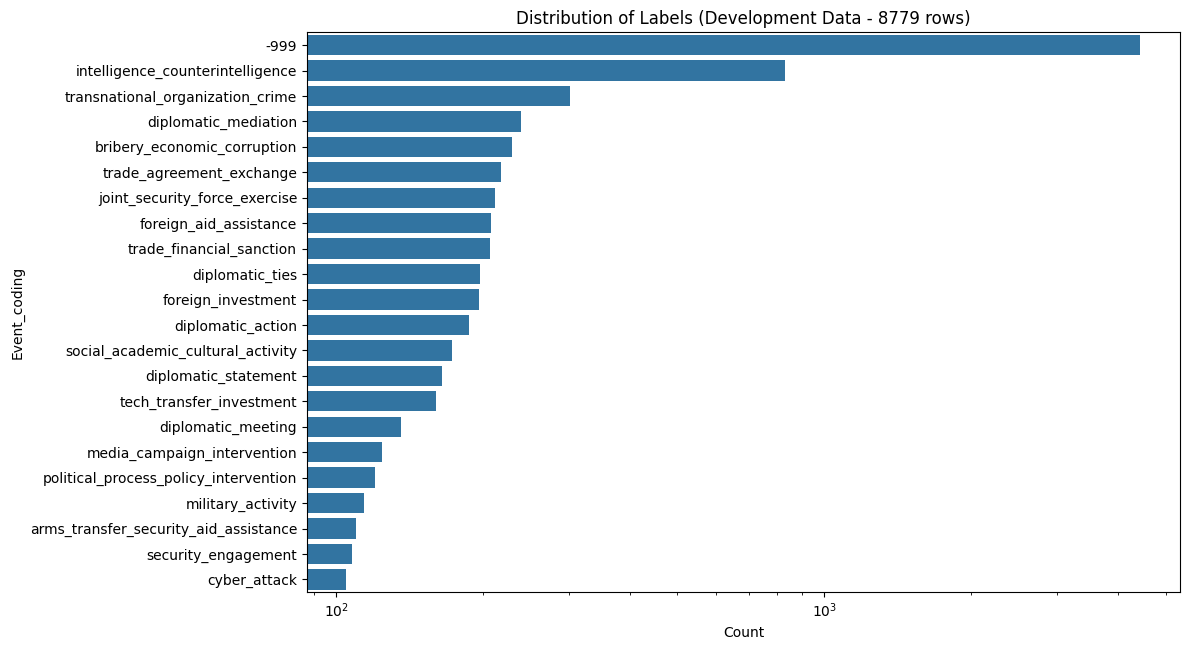

Development Data Label Proportions (%):
Event_coding
-999                                     50.552455
intelligence_counterintelligence          9.465771
transnational_organization_crime          3.440027
diplomatic_mediation                      2.722406
bribery_economic_corruption               2.608498
trade_agreement_exchange                  2.483199
joint_security_force_exercise             2.414854
foreign_aid_assistance                    2.369290
trade_financial_sanction                  2.357900
diplomatic_ties                           2.243991
foreign_investment                        2.232601
diplomatic_action                         2.130083
social_academic_cultural_activity         1.970612
diplomatic_statement                      1.879485
tech_transfer_investment                  1.822531
diplomatic_meeting                        1.549151
media_campaign_intervention               1.412462
political_process_policy_intervention     1.366898
military_activity            

In [ ]:
# --- 💾 Stage 2: Load Preprocessed Data and Split ---
print("\n--- 💾 Stage 2: Loading Preprocessed Data and Splitting ---")
try:
    # Assuming your CLEANED_DATA_PATH is a CSV as per the uploaded file name
    df_processed_full = pd.read_csv(CLEANED_DATA_PATH)
    print(f"Successfully read preprocessed data from '{CLEANED_DATA_PATH}'. Shape: {df_processed_full.shape}")
except FileNotFoundError:
    print(f"CRITICAL Error: Preprocessed data file '{CLEANED_DATA_PATH}' not found.")
    raise SystemExit()
except Exception as e:
    print(f"CRITICAL Error reading preprocessed data file '{CLEANED_DATA_PATH}': {e}")
    raise SystemExit()

# Verify required columns exist in the preprocessed file
required_cols_in_cleaned = [INPUT_TEXT_COLUMN, LABEL_COLUMN]
for col in required_cols_in_cleaned:
    if col not in df_processed_full.columns:
        raise KeyError(f"  Required column '{col}' not found in the preprocessed file '{CLEANED_DATA_PATH}'.")

# Drop any NaNs that might exist in these critical columns
df_processed_full.dropna(subset=[INPUT_TEXT_COLUMN, LABEL_COLUMN], inplace=True)
df_processed_full[LABEL_COLUMN] = df_processed_full[LABEL_COLUMN].astype(str).str.strip()
df_processed_full = df_processed_full[df_processed_full[LABEL_COLUMN].str.len() > 0]
df_processed_full = df_processed_full[df_processed_full[INPUT_TEXT_COLUMN].str.strip().str.len() > 0]

print(f"Shape after NaN drop on critical columns: {df_processed_full.shape}")
if len(df_processed_full) == 0:
    raise ValueError("No data remaining after initial checks on preprocessed file.")


# Stratified split of the preprocessed data
df_dev, df_test = train_test_split(
    df_processed_full,
    test_size=TEST_SET_SIZE,
    random_state=RANDOM_STATE_SPLIT,
    stratify=df_processed_full[LABEL_COLUMN] # Stratify on the original string label column
)
print(f"\nSplit preprocessed dataset: {len(df_dev)} for development (training), {len(df_test)} for held-out test.")

# --- Prepare Labels and Weights using ONLY the Development Set (df_dev) ---
print("Preparing labels and class weights from the DEVELOPMENT set...")
df_dev = df_dev.copy() # Avoid SettingWithCopyWarning
df_test = df_test.copy()

unique_labels_list = sorted(df_dev[LABEL_COLUMN].unique())
num_labels = len(unique_labels_list)
label2id = {label: i for i, label in enumerate(unique_labels_list)}
id2label = {i: label for label, i in label2id.items()}
print(f"  Label Mapping (id2label) created from dev set: {id2label}")
print(f"  Number of unique event classes in dev set: {num_labels}")

df_dev['labels'] = df_dev[LABEL_COLUMN].map(label2id) # Integer labels for dev set

# Map test set labels using label2id from dev set
df_test['labels'] = df_test[LABEL_COLUMN].map(label2id)
unknown_labels_in_test = df_test[df_test['labels'].isnull()][LABEL_COLUMN].unique()
if len(unknown_labels_in_test) > 0:
    print(f"  Warning: Test data contains labels not seen in dev set: {unknown_labels_in_test}. These rows will be dropped for evaluation.")
    df_test.dropna(subset=['labels'], inplace=True)
if len(df_test) > 0:
    df_test['labels'] = df_test['labels'].astype(int)
else:
    print("  Warning: No test data remaining after mapping unknown labels.")


# Visualize Label Distribution for Development Data
plt.figure(figsize=(12, max(6, num_labels * 0.3)))
sns.countplot(y=df_dev[LABEL_COLUMN], order = df_dev[LABEL_COLUMN].value_counts().index)
plt.title(f'Distribution of Labels (Development Data - {len(df_dev)} rows)')
plt.xlabel('Count'); plt.ylabel(LABEL_COLUMN); plt.xscale('log') # Using log scale for potentially large differences
plt.tight_layout(); plt.show()
print("Development Data Label Proportions (%):")
print(df_dev[LABEL_COLUMN].value_counts(normalize=True) * 100)

# Calculate Class Weights from Development Data
class_counts = np.bincount(df_dev['labels'], minlength=num_labels)
if np.any(class_counts == 0):
    print("  Warning: Some classes have zero samples in the dev data! Class weighting will be disabled.")
    class_weights_tensor = None
else:
    class_weights_values = len(df_dev['labels']) / (num_labels * class_counts)
    class_weights_tensor = torch.tensor(class_weights_values, dtype=torch.float)
    print(f"  Calculated Class Weights for Dev Data: {class_weights_tensor.tolist()}")


In [ ]:
# --- ⚙️ Stage 3: Tokenization ---
print("\n--- ⚙️ Stage 3: Tokenization ---")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

def tokenize_function(examples):
    return tokenizer(
        examples[INPUT_TEXT_COLUMN],
        truncation=True,
        padding=False, # Collator handles this
        max_length=MAX_SEQ_LENGTH
    )

def tokenize_dataframe(df_to_tokenize):
    df_for_dataset = df_to_tokenize[[INPUT_TEXT_COLUMN, 'labels']].copy()
    hf_dataset = Dataset.from_pandas(df_for_dataset)
    tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)
    if INPUT_TEXT_COLUMN in tokenized_dataset.column_names: # remove_columns needs existing columns
        tokenized_dataset = tokenized_dataset.remove_columns([INPUT_TEXT_COLUMN])
    return tokenized_dataset

tokenized_dev_dataset_final_train = tokenize_dataframe(df_dev)
tokenized_test_dataset_final_eval = tokenize_dataframe(df_test)

print(f"Development dataset tokenized. Size: {len(tokenized_dev_dataset_final_train)}")
print(f"Held-out test dataset tokenized. Size: {len(tokenized_test_dataset_final_eval)}")



--- ⚙️ Stage 3: Tokenization ---


Map:   0%|          | 0/8779 [00:00<?, ? examples/s]

Map:   0%|          | 0/1550 [00:00<?, ? examples/s]

Development dataset tokenized. Size: 8779
Held-out test dataset tokenized. Size: 1550


In [ ]:
# --- 📊 Stage 4: Metrics, Model Init, Weighted Trainer ---
print("\n--- 📊 Stage 4: Metrics, Model Init, Weighted Trainer ---")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(labels, predictions, average='macro', zero_division=0)
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy, 'macro_f1': f1_macro, 'macro_precision': precision_macro, 'macro_recall': recall_macro}

def model_init_final():
    if num_labels == 0 or id2label is None or label2id is None:
        raise ValueError("Label mappings (num_labels, id2label, label2id) not set. Ensure Stage 2 (dev data prep) ran.")
    return AutoModelForSequenceClassification.from_pretrained(
        MODEL_ID, num_labels=num_labels, id2label=id2label, label2id=label2id, trust_remote_code=True
    )

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        current_device = model.device
        if class_weights_tensor is not None:
            c_weights = class_weights_tensor.to(current_device)
            loss_fct = torch.nn.CrossEntropyLoss(weight=c_weights)
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainer_class_to_use = WeightedTrainer if class_weights_tensor is not None else Trainer
print(f"Using {'WeightedTrainer' if class_weights_tensor is not None else 'standard Trainer'}.")



--- 📊 Stage 4: Metrics, Model Init, Weighted Trainer ---
Using WeightedTrainer.


In [ ]:
# --- 🏁 Stage 5: Final Model Training on Development Data ---
print(f"\n--- 🏁 Stage 5: Training Final Model for {TASK_NAME} on Development Dataset ---")

final_model = model_init_final()

final_training_args = TrainingArguments(
    output_dir=FINAL_MODEL_SAVE_PATH,
    learning_rate=best_hyperparameters["learning_rate"],
    num_train_epochs=best_hyperparameters["num_train_epochs"],
    per_device_train_batch_size=best_hyperparameters["per_device_train_batch_size"],
    per_device_eval_batch_size=8,
    weight_decay=best_hyperparameters["weight_decay"],
    warmup_ratio=best_hyperparameters["warmup_ratio"],
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=SEED,
)

final_trainer = trainer_class_to_use(
    model=final_model,
    args=final_training_args,
    train_dataset=tokenized_dev_dataset_final_train,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

print(f"Starting final model training using HPs: {best_hyperparameters} on the development set.")
try:
    final_trainer.train()
    print("Final model training finished.")
    final_trainer.save_model(FINAL_MODEL_SAVE_PATH)
    tokenizer.save_pretrained(FINAL_MODEL_SAVE_PATH)
    print(f"Final model and tokenizer saved to {FINAL_MODEL_SAVE_PATH}")
except Exception as e:
    print(f"Error during final model training: {e}")
    raise


--- 🏁 Stage 5: Training Final Model for RAI_event_classifier_ModernBERT_Direct_Final on Development Dataset ---


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-40-b6d8b4aeae29>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  final_trainer = trainer_class_to_use(


Starting final model training using HPs: {'learning_rate': 1.4708939303229212e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.055737672961265396, 'warmup_ratio': 0.026322352100573498} on the development set.


Step,Training Loss
1098,0.989400
2196,0.273700
3294,0.054100


Final model training finished.
Final model and tokenizer saved to ./RAI_event_classifier_ModernBERT_Direct_Final_deployment_model



--- 🧪 Stage 6: Evaluating Final Model, Saving Disagreements, & Zipping ---
Successfully loaded original raw data from '/content/RAI_event_coding_05272025.xlsx' for disagreements. Shape: (10340, 7)
Loading final trained model from: ./RAI_event_classifier_ModernBERT_Direct_Final_deployment_model for test evaluation.
Model and tokenizer for testing loaded successfully.


<ipython-input-42-9da639a76995>:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  test_trainer = trainer_class_for_eval(



Making predictions on the HELD-OUT test data...



--- 📊 Classification Report on HELD-OUT Test Data ---
                                       precision    recall  f1-score   support

                                 -999     0.9532    0.9374    0.9453       783
arms_transfer_security_aid_assistance     0.8636    1.0000    0.9268        19
          bribery_economic_corruption     0.9286    0.9512    0.9398        41
                         cyber_attack     0.9474    1.0000    0.9730        18
                    diplomatic_action     0.8485    0.8485    0.8485        33
                 diplomatic_mediation     0.9024    0.8810    0.8916        42
                   diplomatic_meeting     0.8333    0.8333    0.8333        24
                 diplomatic_statement     0.7692    0.6897    0.7273        29
                      diplomatic_ties     0.9143    0.9143    0.9143        35
               foreign_aid_assistance     0.9231    0.9730    0.9474        37
                   foreign_investment     0.8250    0.9429    0.8800       

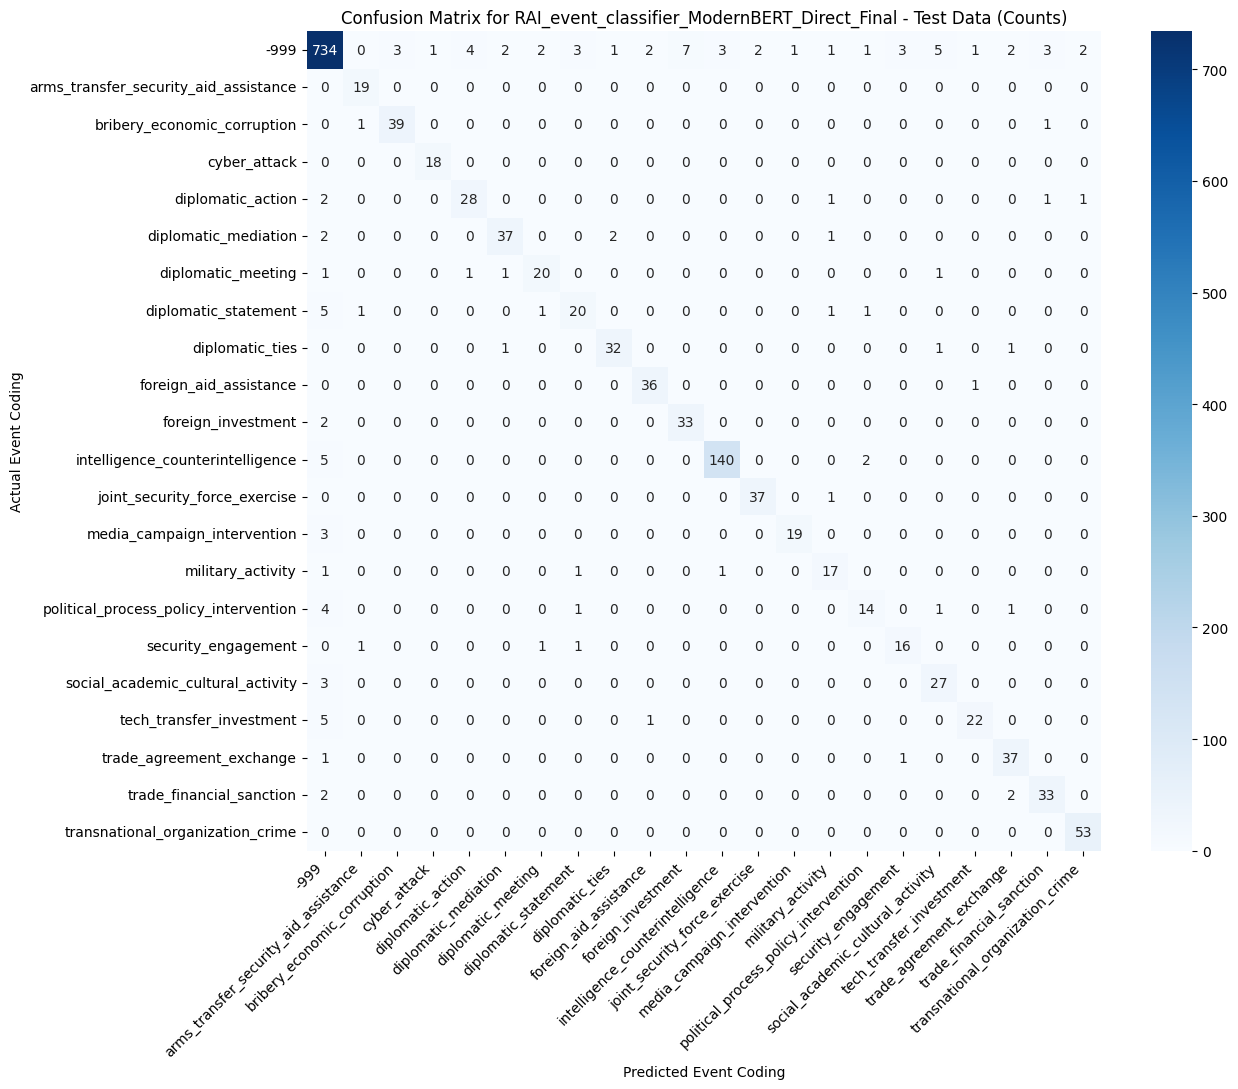

Test set confusion matrix (counts) saved to ./RAI_event_classifier_ModernBERT_Direct_Final_TEST_SET_confusion_matrix_counts.png

--- Overall HELD-OUT Test Metrics (Calculated by Trainer) ---
test_loss: 0.5280
test_model_preparation_time: 0.0039
test_accuracy: 0.9232
test_macro_f1: 0.8834
test_macro_precision: 0.8770
test_macro_recall: 0.8930
test_runtime: 8.6117
test_samples_per_second: 179.9880
test_steps_per_second: 22.5280
df_test_final_processed not available, cannot create disagreements file.

--- ዚ Stage 7: Zipping the Final Trained Model ---
Model folder './RAI_event_classifier_ModernBERT_Direct_Final_deployment_model' successfully zipped to './RAI_event_classifier_ModernBERT_Direct_Final_deployment_model_archive.zip'

--- 🎉 Script Finished ---


In [ ]:
# --- (Ensure all necessary imports from your script are present) ---
# import pandas as pd, numpy as np, torch, matplotlib.pyplot as plt, seaborn as sns, json
# from datasets import Dataset
# from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
# from sklearn.metrics import classification_report, confusion_matrix

# --- (Assuming all previous stages have run, and variables like
#      FINAL_MODEL_SAVE_PATH, TASK_NAME, tokenized_test_dataset_final_eval,
#      id2label, num_labels,
#      INPUT_TEXT_COLUMN, LABEL_COLUMN (Event_coding),
#      compute_metrics, WeightedTrainer (or Trainer as trainer_class_to_use),
#      tokenizer, data_collator are defined,
#      AND df_test_final_processed (the pandas DataFrame version of your test set,
#      with 'labels' and original 'Event_coding' string label) is available.
#      AND your ORIGINAL RAW DATA FILE 'RAI_event_coding_05272025.xlsx' is in /content/
# ---

# --- 🧪 Stage 6: Evaluate Final Trained Model, Save Disagreements, & Zip ---
print(f"\n--- 🧪 Stage 6: Evaluating Final Model, Saving Disagreements, & Zipping ---")

# --- 6.1: Load Original Raw Data (for disagreements file) ---
ORIGINAL_RAW_DATA_PATH = '/content/RAI_event_coding_05272025.xlsx'
df_original_raw = None
try:
    df_original_raw = pd.read_excel(ORIGINAL_RAW_DATA_PATH)
    print(f"Successfully loaded original raw data from '{ORIGINAL_RAW_DATA_PATH}' for disagreements. Shape: {df_original_raw.shape}")
except FileNotFoundError:
    print(f"WARNING: Original raw data file '{ORIGINAL_RAW_DATA_PATH}' not found. Cannot create detailed disagreements file with all original columns.")
except Exception as e:
    print(f"WARNING: Error loading original raw data file '{ORIGINAL_RAW_DATA_PATH}': {e}. Cannot create detailed disagreements file.")

# --- 6.2: Load Saved Final Model and Make Predictions ---
if 'tokenized_test_dataset_final_eval' not in locals() or tokenized_test_dataset_final_eval is None or \
   'id2label' not in locals() or id2label is None or \
   'num_labels' not in locals() or num_labels == 0:
    print("CRITICAL Error: Required variables (tokenized_test_dataset_final_eval, id2label, num_labels) not defined. Skipping Stage 6.")
else:
    if len(tokenized_test_dataset_final_eval) == 0 :
        print("Skipping final test set evaluation as the tokenized test dataset is empty.")
    else:
        print(f"Loading final trained model from: {FINAL_MODEL_SAVE_PATH} for test evaluation.")
        try:
            loaded_model_for_test = AutoModelForSequenceClassification.from_pretrained(FINAL_MODEL_SAVE_PATH)
            # Tokenizer was saved with the model in Stage 5
            loaded_tokenizer_for_test = AutoTokenizer.from_pretrained(FINAL_MODEL_SAVE_PATH)
            print("Model and tokenizer for testing loaded successfully.")
        except OSError:
            print(f"CRITICAL Error: Could not load model from {FINAL_MODEL_SAVE_PATH}.")
            raise SystemExit()

        test_eval_args = TrainingArguments(
            output_dir=f"./{TASK_NAME}_final_test_results_output", # Temporary dir for this eval
            per_device_eval_batch_size=8,
            fp16=torch.cuda.is_available(),
            report_to="none"
        )

        # Determine which trainer class was used for consistency, though for .predict() standard Trainer is often fine
        trainer_class_for_eval = WeightedTrainer if 'WeightedTrainer' in globals() and class_weights_tensor is not None else Trainer

        test_trainer = trainer_class_for_eval(
            model=loaded_model_for_test,
            args=test_eval_args,
            tokenizer=loaded_tokenizer_for_test,
            data_collator=data_collator, # Ensure data_collator is defined globally
            compute_metrics=compute_metrics # Ensure compute_metrics is defined globally
        )

        print("\nMaking predictions on the HELD-OUT test data...")
        predictions_output = test_trainer.predict(tokenized_test_dataset_final_eval)
        predicted_logits = predictions_output.predictions
        predicted_ids = np.argmax(predicted_logits, axis=1)

        # !!! CORRECTION: Define true_ids_test from predictions_output.label_ids HERE !!!
        true_ids_test = predictions_output.label_ids

        # Convert integer predictions and true labels back to string labels for reporting
        predicted_labels_str_test = [id2label.get(i, f"UnknownID_{i}") for i in predicted_ids]
        true_labels_str_test_report = [id2label.get(i, f"UnknownID_{i}") for i in true_ids_test]
        class_names_for_report = [id2label[i] for i in range(num_labels)] # Uses order from dev data mapping

        # --- 6.3: Classification Report and Confusion Matrix ---
        print("\n--- 📊 Classification Report on HELD-OUT Test Data ---")
        report = classification_report(
            true_labels_str_test_report, predicted_labels_str_test, labels=class_names_for_report,
            zero_division=0, digits=4
        )
        print(report)
        df_report = pd.DataFrame(classification_report(
            true_labels_str_test_report, predicted_labels_str_test, labels=class_names_for_report,
            zero_division=0, output_dict=True, digits=4
        )).transpose()
        report_save_path = f"./{TASK_NAME}_TEST_SET_classification_report.xlsx"
        df_report.to_excel(report_save_path)
        print(f"Test set classification report saved to {report_save_path}")

        print("\n--- 🖼️ Confusion Matrix on HELD-OUT Test Data ---")
        cm = confusion_matrix(true_labels_str_test_report, predicted_labels_str_test, labels=class_names_for_report)
        plt.figure(figsize=(max(10, num_labels * 0.6), max(8, num_labels * 0.5)))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names_for_report, yticklabels=class_names_for_report)
        plt.title(f'Confusion Matrix for {TASK_NAME} - Test Data (Counts)')
        plt.ylabel('Actual Event Coding'); plt.xlabel('Predicted Event Coding')
        plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
        cm_save_path = f"./{TASK_NAME}_TEST_SET_confusion_matrix_counts.png"
        plt.savefig(cm_save_path); plt.show()
        print(f"Test set confusion matrix (counts) saved to {cm_save_path}")

        print("\n--- Overall HELD-OUT Test Metrics (Calculated by Trainer) ---")
        # The Trainer's predict method also calls compute_metrics if available
        if predictions_output.metrics:
            for name, value in predictions_output.metrics.items():
                print(f"{name.replace('eval_', 'test_')}: {value:.4f}") # Rename eval_ to test_
        else: # Fallback if metrics weren't populated
            manual_metrics = compute_metrics((predicted_logits, true_ids_test)) # Pass true_ids_test
            for name, value in manual_metrics.items(): print(f"test_{name}: {value:.4f}")

        # --- 6.4: Save Disagreements File ---
        # Ensure df_test_final_processed is available and has the correct index
        if 'df_test_final_processed' in locals() and df_test_final_processed is not None and df_original_raw is not None:
            print("\n--- 📁 Saving Disagreements File ---")

            # Add predictions to df_test_final_processed for easy comparison
            # df_test_final_processed might not exist if test data loading failed
            # Ensure indices align if df_test_final_processed was modified (e.g. by dropping NaNs after label mapping)

            temp_test_df_for_disagreements = df_test_final_processed.copy()
            # It's safer to ensure lengths match after any NA drops in test label mapping
            if len(temp_test_df_for_disagreements) == len(predicted_labels_str_test):
                temp_test_df_for_disagreements['predicted_Event_coding_by_model'] = predicted_labels_str_test
                temp_test_df_for_disagreements['true_Event_coding_from_data'] = temp_test_df_for_disagreements[LABEL_COLUMN]


                disagreements_mask = (temp_test_df_for_disagreements['predicted_Event_coding_by_model'] != temp_test_df_for_disagreements['true_Event_coding_from_data'])
                disagreement_indices = temp_test_df_for_disagreements.index[disagreements_mask]

                if not disagreement_indices.empty:
                    # Assuming df_original_raw's index aligns with the indices from df_test_final_processed
                    # This alignment is crucial and was established during the initial train_test_split of df_processed_full
                    # if df_processed_full itself maintained original indexing or if reset_index(drop=True) was used consistently.

                    disagreed_original_rows = df_original_raw.loc[disagreement_indices].copy()

                    # Add the model's input, its prediction, and the true label to these original rows
                    disagreed_original_rows['MODEL_INPUT_TEXT'] = temp_test_df_for_disagreements.loc[disagreement_indices, INPUT_TEXT_COLUMN]
                    disagreed_original_rows['MODEL_PREDICTED_Event_Coding'] = temp_test_df_for_disagreements.loc[disagreement_indices, 'predicted_Event_coding_by_model']
                    disagreed_original_rows['DATA_TRUE_Event_Coding'] = temp_test_df_for_disagreements.loc[disagreement_indices, 'true_Event_coding_from_data']

                    disagreements_save_path = f"./{TASK_NAME}_TEST_SET_disagreements.xlsx"
                    disagreed_original_rows.to_excel(disagreements_save_path, index=False) # Save without pandas index
                    print(f"Disagreements file with original columns saved to {disagreements_save_path}")
                    print(f"  Number of disagreements: {len(disagreed_original_rows)}")
                else:
                    print("No disagreements found between predictions and true labels on the test set.")
            else:
                print("WARNING: Length mismatch between test dataframe and predictions. Cannot reliably create disagreements file.")
        elif df_original_raw is None:
            print("Original raw data file not loaded, cannot create detailed disagreements file.")
        else:
            print("df_test_final_processed not available, cannot create disagreements file.")
    # ... (else for skipping evaluation if test data failed to load) ...

# --- 7. Zip the Final Model ---
print(f"\n--- ዚ Stage 7: Zipping the Final Trained Model ---")
try:
    import shutil
    shutil.make_archive(f"{FINAL_MODEL_SAVE_PATH}_archive", 'zip', FINAL_MODEL_SAVE_PATH)
    print(f"Model folder '{FINAL_MODEL_SAVE_PATH}' successfully zipped to '{FINAL_MODEL_SAVE_PATH}_archive.zip'")
except Exception as e:
    print(f"Error zipping the model folder: {e}")
    print(f"You might need to run: !zip -r {FINAL_MODEL_SAVE_PATH}.zip {FINAL_MODEL_SAVE_PATH} in a new cell.")

print("\n--- 🎉 Script Finished ---")


--- 🖼️ Confusion Matrix on HELD-OUT Test Data (Counts) ---


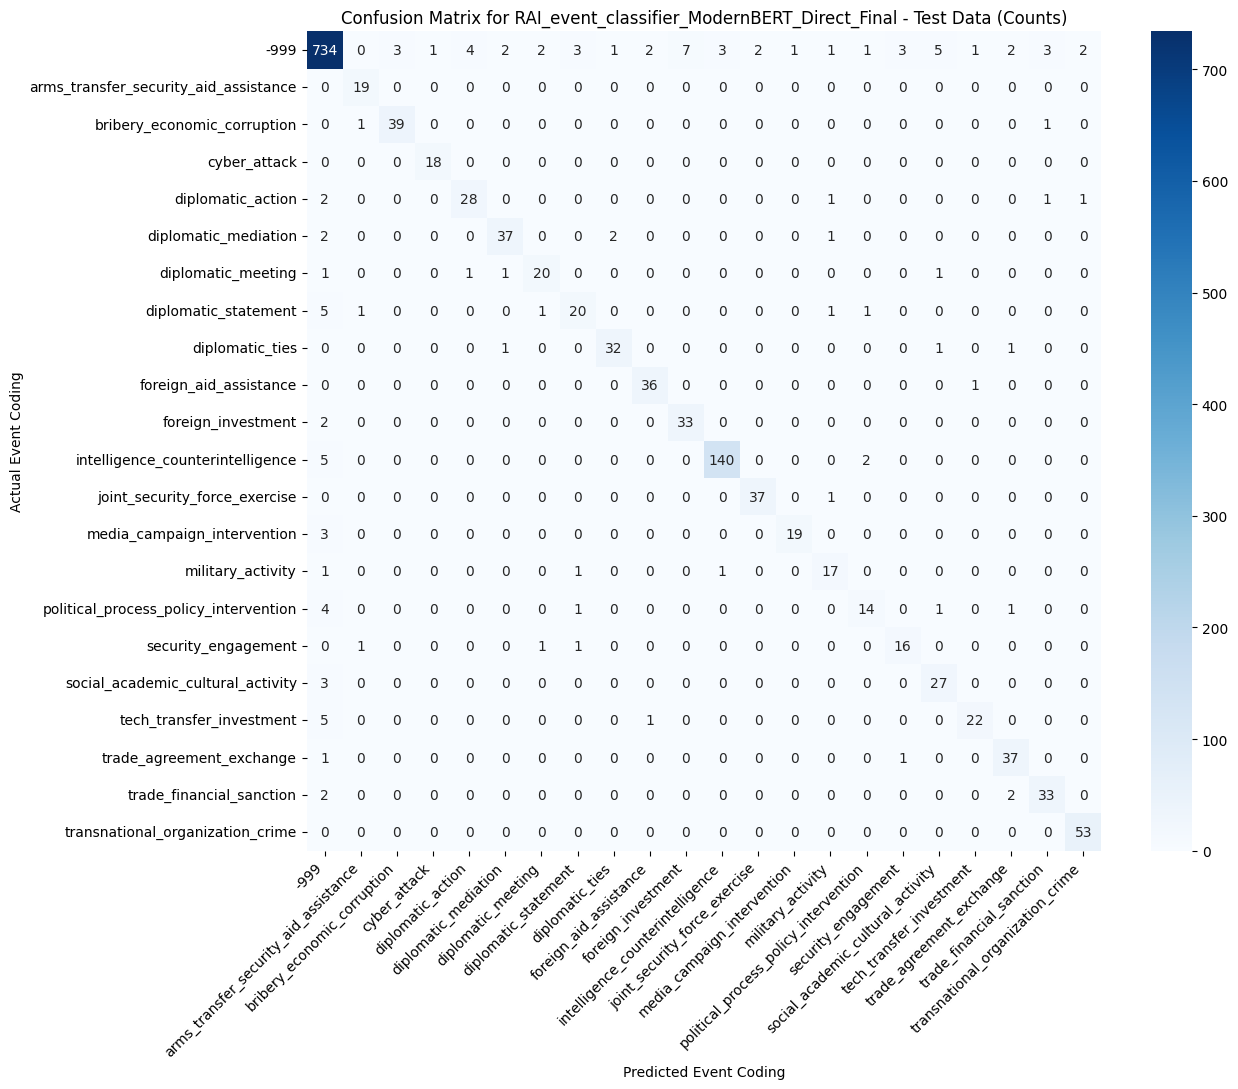

Test set confusion matrix (counts) saved to ./RAI_event_classifier_ModernBERT_Direct_Final_TEST_SET_confusion_matrix_counts.png

--- 🖼️ Normalized Confusion Matrix on HELD-OUT Test Data (Row-wise %) ---


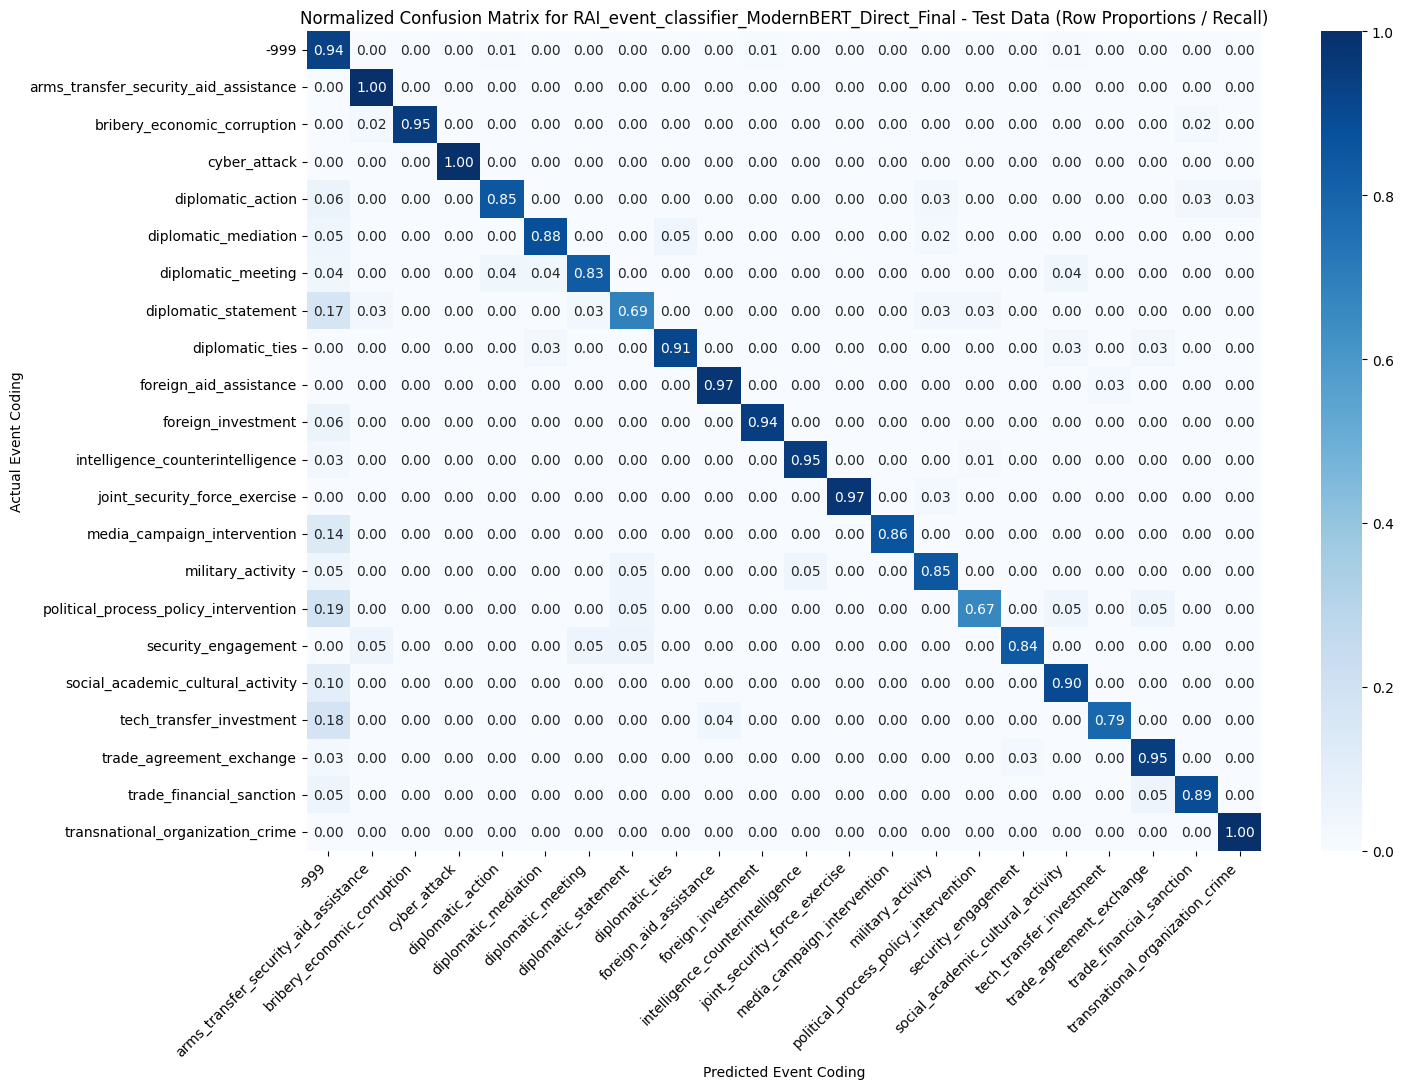

Test set row-normalized confusion matrix saved to ./RAI_event_classifier_ModernBERT_Direct_Final_TEST_SET_confusion_matrix_normalized_row.png


In [ ]:
print("\n--- 🖼️ Confusion Matrix on HELD-OUT Test Data (Counts) ---")
cm = confusion_matrix(true_labels_str_test_report, predicted_labels_str_test, labels=class_names_for_report)
plt.figure(figsize=(max(10, num_labels * 0.6), max(8, num_labels * 0.5))) # Dynamic sizing
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_for_report, yticklabels=class_names_for_report)
plt.title(f'Confusion Matrix for {TASK_NAME} - Test Data (Counts)')
plt.ylabel('Actual Event Coding'); plt.xlabel('Predicted Event Coding')
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
cm_save_path = f"./{TASK_NAME}_TEST_SET_confusion_matrix_counts.png"
plt.savefig(cm_save_path); plt.show()
print(f"Test set confusion matrix (counts) saved to {cm_save_path}")

# --- ✨ NEW: Normalized Confusion Matrix (Row-wise, 0 to 1 representing accuracy per class) ---
print("\n--- 🖼️ Normalized Confusion Matrix on HELD-OUT Test Data (Row-wise %) ---")
# Calculate row sums, handle potential division by zero if a class has no true samples in test set
row_sums = cm.sum(axis=1)[:, np.newaxis]
# Replace 0s in row_sums with 1 to avoid division by zero; result will be 0 for that row.
# Alternatively, filter out classes with no support before this step if desired.
safe_row_sums = np.where(row_sums == 0, 1, row_sums)
cm_normalized_row = cm.astype('float') / safe_row_sums

plt.figure(figsize=(max(10, num_labels * 0.6) + 2, max(8, num_labels * 0.5))) # Slightly wider for color bar
sns.heatmap(cm_normalized_row, annot=True, fmt='.2f', cmap='Blues', # Format as float with 2 decimal places
            xticklabels=class_names_for_report, yticklabels=class_names_for_report,
            vmin=0, vmax=1) # Ensure color scale is 0 to 1
plt.title(f'Normalized Confusion Matrix for {TASK_NAME} - Test Data (Row Proportions / Recall)')
plt.ylabel('Actual Event Coding')
plt.xlabel('Predicted Event Coding')
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout()
cm_norm_save_path = f"./{TASK_NAME}_TEST_SET_confusion_matrix_normalized_row.png"
plt.savefig(cm_norm_save_path); plt.show()
print(f"Test set row-normalized confusion matrix saved to {cm_norm_save_path}")


In [ ]:
# --- 4.3: Save Disagreements File ---
if df_original_raw is not None and 'df_test' in locals() and df_test is not None:
    print("\n--- 📁 Saving Disagreements File ---")

    # df_test is the pandas DataFrame portion of your preprocessed data that was used for testing.
    # It should still have its original index that can map back to df_original_raw.
    # predicted_ids are for tokenized_test_dataset_final_eval, which was made from df_test.

    # Ensure df_test has the same length as predictions before trying to assign
    if len(df_test) == len(predicted_ids):
        # Create a temporary copy for adding prediction columns
        df_test_with_preds = df_test.copy()
        df_test_with_preds['model_predicted_label_id'] = predicted_ids
        df_test_with_preds['model_predicted_Event_coding'] = df_test_with_preds['model_predicted_label_id'].map(id2label)

        # Identify disagreements
        # LABEL_COLUMN is the original string label in df_test
        disagreements_mask = (df_test_with_preds['model_predicted_Event_coding'] != df_test_with_preds[LABEL_COLUMN])
        disagreement_df_test_rows = df_test_with_preds[disagreements_mask]

        if not disagreement_df_test_rows.empty:
            # The indices of disagreement_df_test_rows are from df_original_full (which was split into df_dev and df_test)
            # and should align with df_original_raw if it was loaded with a simple 0-based index.
            disagreed_original_full_rows = df_original_raw.loc[disagreement_df_test_rows.index].copy()

            # Add the model's input, prediction, and true label from the test set
            disagreed_original_full_rows['MODEL_INPUT_TEXT_SEEN_BY_MODEL'] = disagreement_df_test_rows[INPUT_TEXT_COLUMN]
            disagreed_original_full_rows['MODEL_PREDICTED_Event_Coding'] = disagreement_df_test_rows['model_predicted_Event_coding']
            # The 'DATA_TRUE_Event_Coding' is already the LABEL_COLUMN in disagreed_original_full_rows

            disagreements_save_path = f"./{TASK_NAME}_TEST_SET_disagreements.xlsx"
            disagreed_original_full_rows.to_excel(disagreements_save_path, index=False)
            print(f"Disagreements file with original columns saved to {disagreements_save_path}")
            print(f"  Number of disagreements: {len(disagreed_original_full_rows)}")
        else:
            print("🎉 No disagreements found on the test set.")
    else:
        print("WARNING: Length mismatch between df_test and predictions. Cannot create disagreements file reliably.")
elif df_original_raw is None:
    print("WARNING: Original raw data file not loaded. Cannot create detailed disagreements file.")
else:
    print("WARNING: df_test (the pandas DataFrame for the test set) is not available. Cannot create disagreements file.")



--- 📁 Saving Disagreements File ---
Disagreements file with original columns saved to ./RAI_event_classifier_ModernBERT_Direct_Final_TEST_SET_disagreements.xlsx
  Number of disagreements: 119


In [ ]:
# --- 7. Zip the Final Model ---
print(f"\n--- ዚ Stage 7: Zipping the Final Trained Model ---")
try:
    import shutil
    shutil.make_archive(f"{FINAL_MODEL_SAVE_PATH}_archive", 'zip', FINAL_MODEL_SAVE_PATH)
    print(f"Model folder '{FINAL_MODEL_SAVE_PATH}' successfully zipped to '{FINAL_MODEL_SAVE_PATH}_archive.zip'")
except Exception as e:
    print(f"Error zipping the model folder: {e}")
    print(f"You might need to run: !zip -r {FINAL_MODEL_SAVE_PATH}.zip {FINAL_MODEL_SAVE_PATH} in a new cell.")

print("\n--- 🎉 Script Finished ---")

In [ ]:
# --- 7. Zip the Final Model ---
print(f"\n--- ዚ Stage 7: Zipping the Final Trained Model ---")
try:
    import shutil
    shutil.make_archive(f"./RAI_event_classifier_ModernBERT_FullFT_final_model_deployment_archive", 'zip', "./RAI_event_classifier_ModernBERT_FullFT_final_model_deployment")
    print(f"Model folder './RAI_event_classifier_ModernBERT_FullFT_final_model_deployment' successfully zipped to './RAI_event_classifier_ModernBERT_FullFT_final_model_deployment_archive.zip'")
except Exception as e:
    print(f"Error zipping the model folder: {e}")
    print(f"You might need to run: !zip -r /content/RAI_event_classifier_ModernBERT_FullFT_final_model_deployment.zip /content/RAI_event_classifier_ModernBERT_FullFT_final_model_deployment in a new cell.")

print("\n--- 🎉 Script Finished ---")


--- ዚ Stage 7: Zipping the Final Trained Model ---
Model folder './RAI_event_classifier_ModernBERT_FullFT_final_model_deployment' successfully zipped to './RAI_event_classifier_ModernBERT_FullFT_final_model_deployment_archive.zip'

--- 🎉 Script Finished ---
